In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Visuals

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates
import random
from datetime import datetime 
import math
%matplotlib inline

df = pd.read_csv("/content/drive/MyDrive/Pollution Data/SensorData_TwoYears_new.csv")
df.columns

Index(['Datetime', 'PM-2.5', 'Temp', 'Humidity'], dtype='object')

In [3]:
sensordata = [[], [], [], []]
datasetSize = len(df['Datetime'])
invalids = 0
for ind in range(datasetSize):
    if (df['Temp'][ind] > 200 or df['Humidity'][ind] > 100 or 
        math.isnan(df['Temp'][ind]) or math.isnan(df['Humidity'][ind])):
        invalids += 1
        continue
    dt = datetime.strptime(df['Datetime'][ind], '%Y/%m/%dT%H:%M:%Sz')
    sensordata[0].append(dt)
    sensordata[1].append(df['PM-2.5'][ind])
    sensordata[2].append(df['Temp'][ind])
    sensordata[3].append(df['Humidity'][ind])

datasetSize, len(sensordata[0]), invalids

(541841, 532140, 9701)

In [4]:
params = {'legend.fontsize': 57,
          'figure.figsize': (70, 30),
         'axes.labelsize': 57,
         'axes.titlesize': 65,
          'axes.titlecolor': '#cc5f10',
         'axes.labelcolor': '#003891',
         'xtick.labelsize': 47,
         'ytick.labelsize': 47}

def Set_Plot(plt):
    plt.rcParams.update(params)
    plt.legend(numpoints=10, loc='upper right')
    plt.ylabel('PM')
    plt.xlabel('UTC TIME')


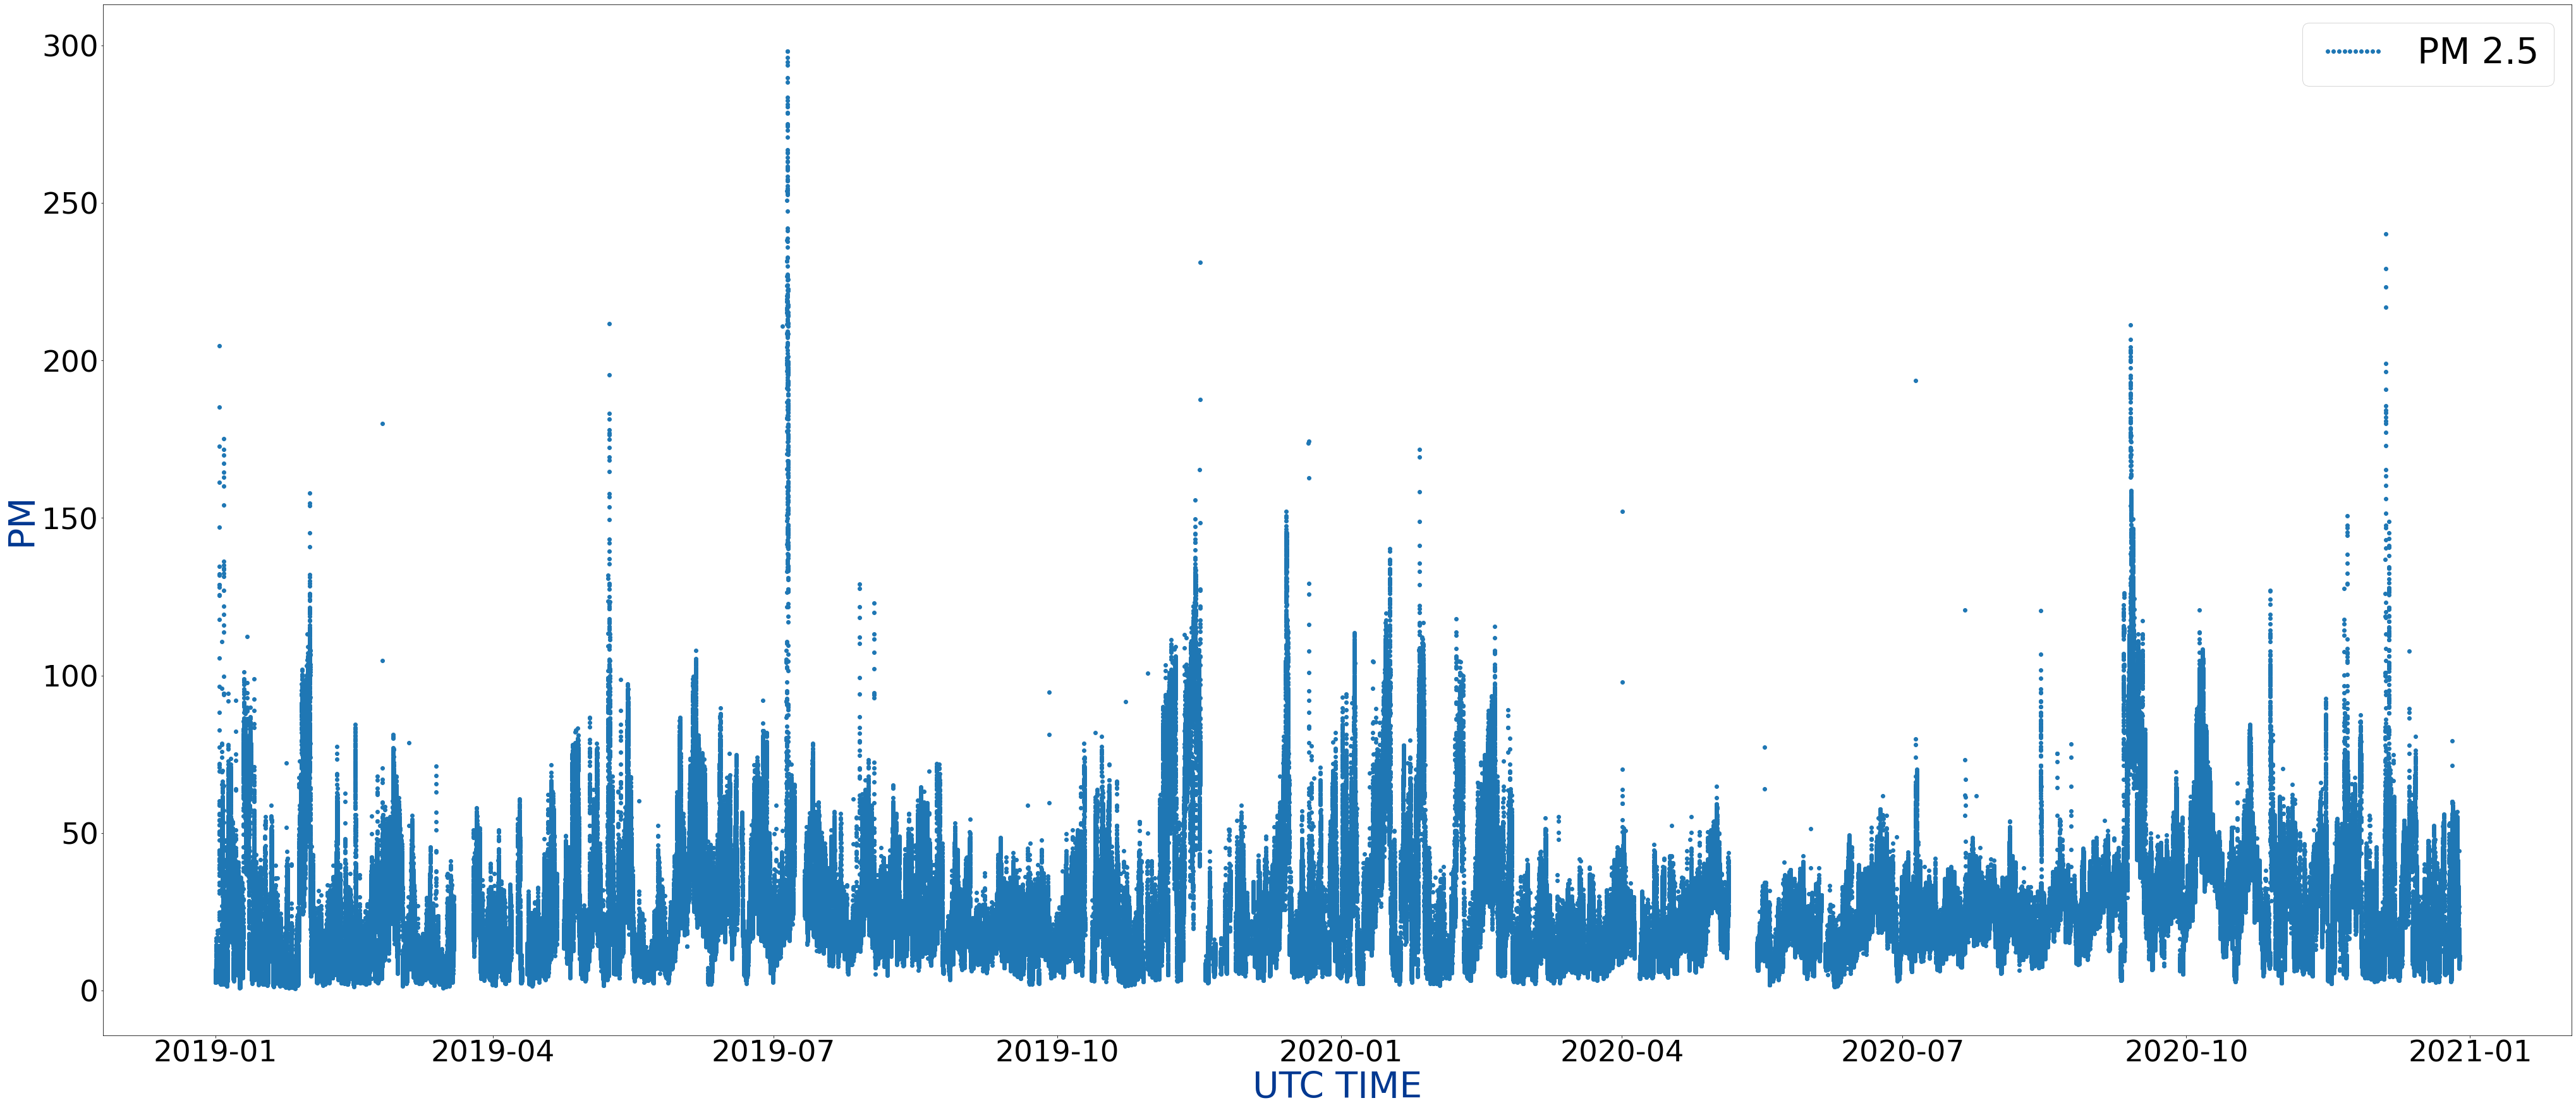

In [29]:
plt.plot_date(sensordata[0], sensordata[1], label = 'PM 2.5')
Set_Plot(plt)

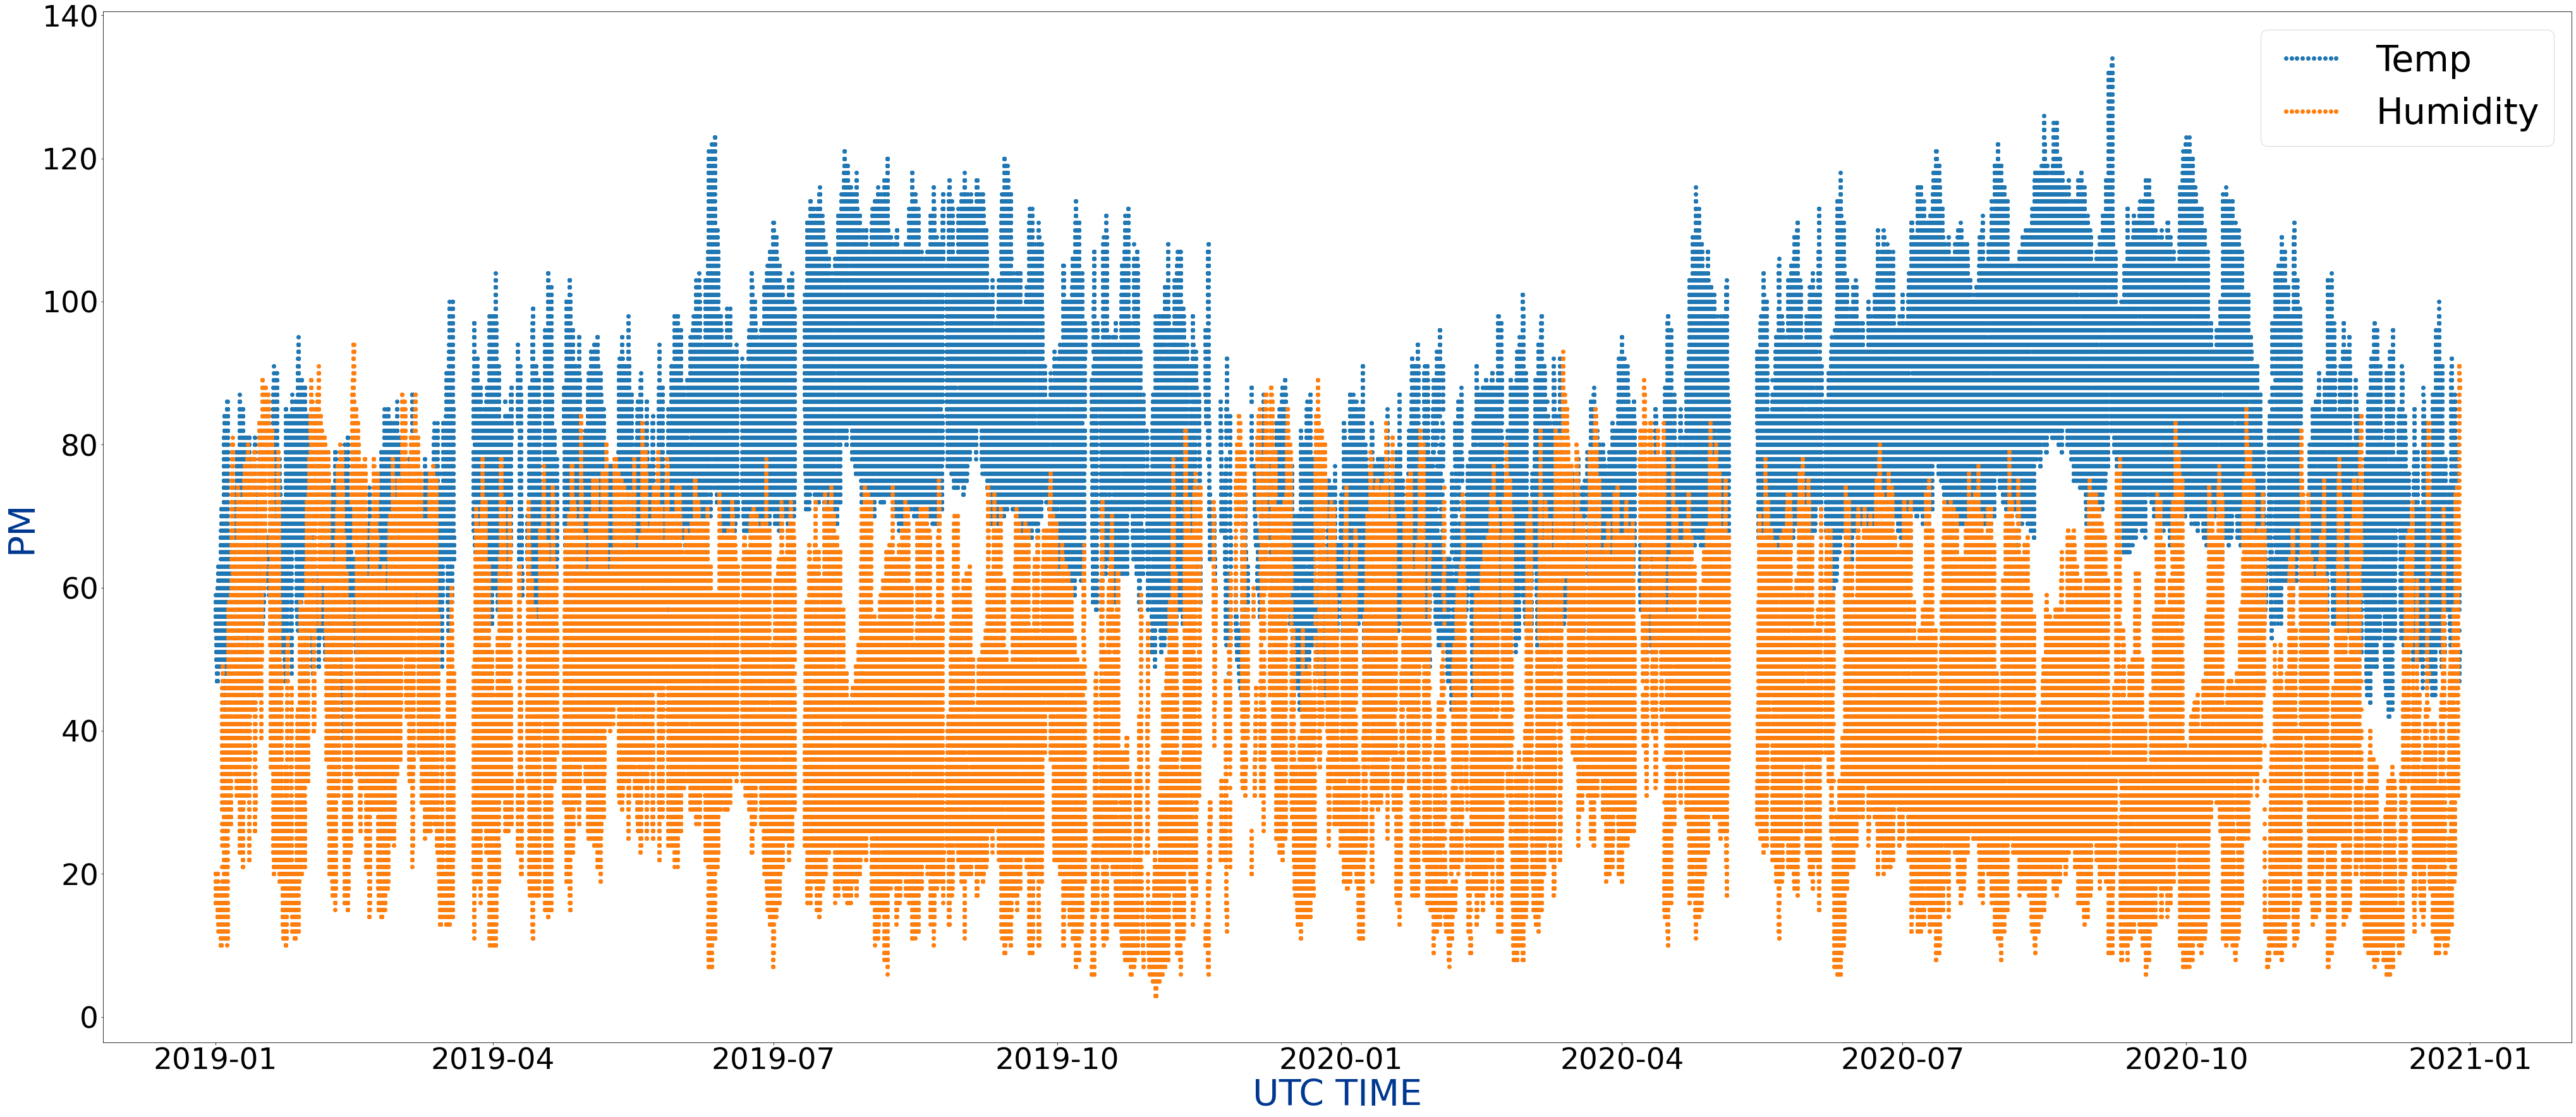

In [6]:
# df['Pam-a']
plt.plot_date(sensordata[0], sensordata[2], label = 'Temp')
plt.plot_date(sensordata[0], sensordata[3], label = 'Humidity')
Set_Plot(plt)

#### 1. Sensordata has all the data in csv except nan or Irregular values. 
#### 2. We will use these missing datetimes while testing.

## Hourly-Data

In [7]:
hourlydata = [[], [], [], []]
ind, sm_pm, sm_tp, sm_hdt, count = 0, 0, 0, 0, 1

dataSize = len(sensordata[0])

while ind < dataSize-1:
    if (sensordata[0][ind].hour) == (sensordata[0][ind+1].hour):
        sm_pm += sensordata[1][ind]
        sm_tp += sensordata[2][ind]
        sm_hdt += sensordata[3][ind]
        count += 1
    elif sensordata[0][ind].hour != sensordata[0][ind+1].hour or ind == dataSize-1:
        avg_pm, avg_tp, avg_hdt = (sm_pm / count), (sm_tp / count), (sm_hdt / count)
        hourlydata[0].append(sensordata[0][ind])
        hourlydata[1].append(avg_pm)
        hourlydata[2].append(avg_tp)
        hourlydata[3].append(avg_hdt)
        sm_pm, sm_tp, sm_hdt = 0, 0, 0
        count = 1
    ind += 1

print(hourlydata[0][0], hourlydata[1][0], hourlydata[2][0], hourlydata[3][0])

2019-01-01 00:59:23 3.7611363636363637 55.81818181818182 17.136363636363637


In [8]:
len(hourlydata[0])

16272

## GBR Implementation for 2-Years of Data 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
x_hrdata = pd.DataFrame({ 'weekday':[x.weekday() for x in hourlydata[0]],
                         'date':[x.day for x in hourlydata[0]], 
                      'month':[x.month for x in hourlydata[0]], 
                      'year':[x.year for x in hourlydata[0]], 
                      'hour':[x.hour for x in hourlydata[0]],
                      'temp':hourlydata[2],
                      'humidity':hourlydata[3]})
y_hrdata = pd.Series(hourlydata[1])

x_hrdata.head(), ' ',  y_hrdata.head()

(   weekday  date  month  year  hour       temp   humidity
 0        1     1      1  2019     0  55.818182  17.136364
 1        1     1      1  2019     1  53.977273  19.204545
 2        1     1      1  2019     2  53.622222  19.311111
 3        1     1      1  2019     3  53.372093  16.906977
 4        1     1      1  2019     5  51.409091  17.181818, ' ', 0    3.761136
 1    4.435000
 2    4.430889
 3    4.726977
 4    5.300000
 dtype: float64)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_hrdata, y_hrdata, test_size=0.2)
#gradient regressor model
gradRegressor = gbr(max_depth=2, n_estimators=3, learning_rate=0.1)

model = gradRegressor.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.045949369584831756

In [ ]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.5], 'n_estimators':[2500, 3000], 'max_depth':[8]}
tuning = GridSearchCV( estimator = gbr(), param_grid = LR, scoring = 'r2')
model = tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 3000},
 0.7500256848905283)

In [ ]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.4, 0.5], 'n_estimators':[3200], 'max_depth':[8]}
tuning = GridSearchCV( estimator = gbr(), param_grid = LR, scoring = 'r2')
model = tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.4, 'max_depth': 8, 'n_estimators': 3200},
 0.7917038588101425)

In [ ]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.3, 0.4], 'n_estimators':[3400], 'max_depth':[8]}
tuning = GridSearchCV( estimator = gbr(), param_grid = LR, scoring = 'r2')
model = tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 3400},
 0.8094067665718502)

In [ ]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.2, 0.3], 'n_estimators':[3600], 'max_depth':[8]}
tuning = GridSearchCV( estimator = gbr(), param_grid = LR, scoring = 'r2')
model = tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 3600},
 0.8249389018231146)

In [12]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.1, 0.2], 'n_estimators':[3800], 'max_depth':[8]}
tuning = GridSearchCV( estimator = gbr(), param_grid = LR, scoring = 'r2')
model = tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 3800},
 0.8209607965042729)

R-squared  0.8307097857889697
RMSE  7.8321376690198115


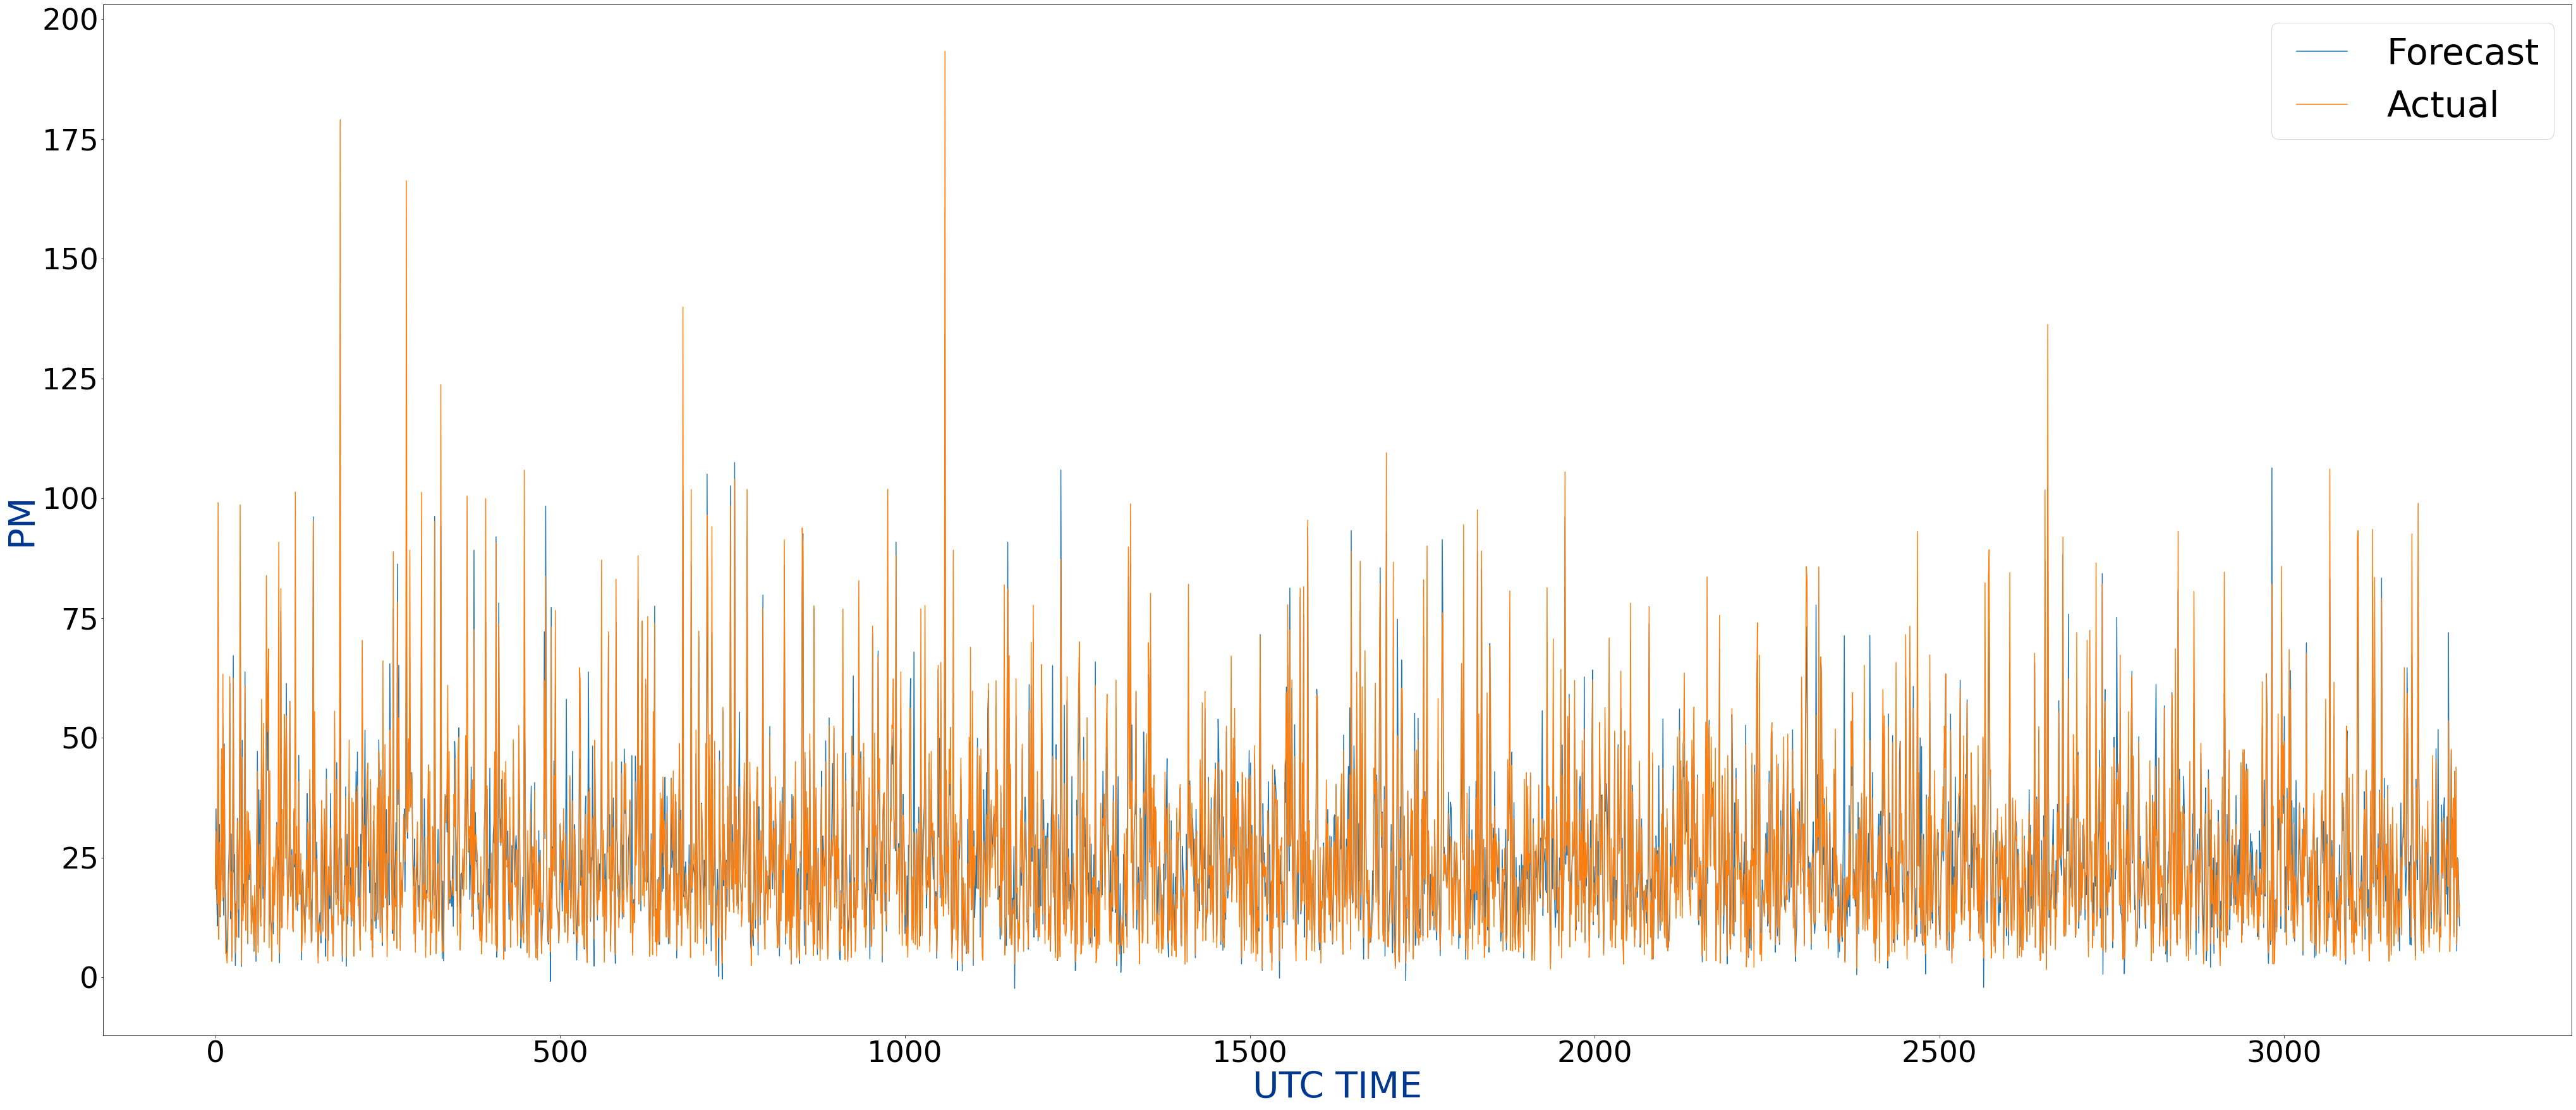

In [13]:
from sklearn.metrics import mean_squared_error 
from math import sqrt

testing = [ind for ind in range(len(y_test))]
y_pred = model.predict(x_test)
print('R-squared ', r2_score(y_true=y_test, y_pred=y_pred))
print('RMSE ', sqrt(mean_squared_error(y_test, y_pred)))
plt.plot(testing, y_pred, label='Forecast')
plt.plot(testing, y_test, label='Actual')
Set_Plot(plt)


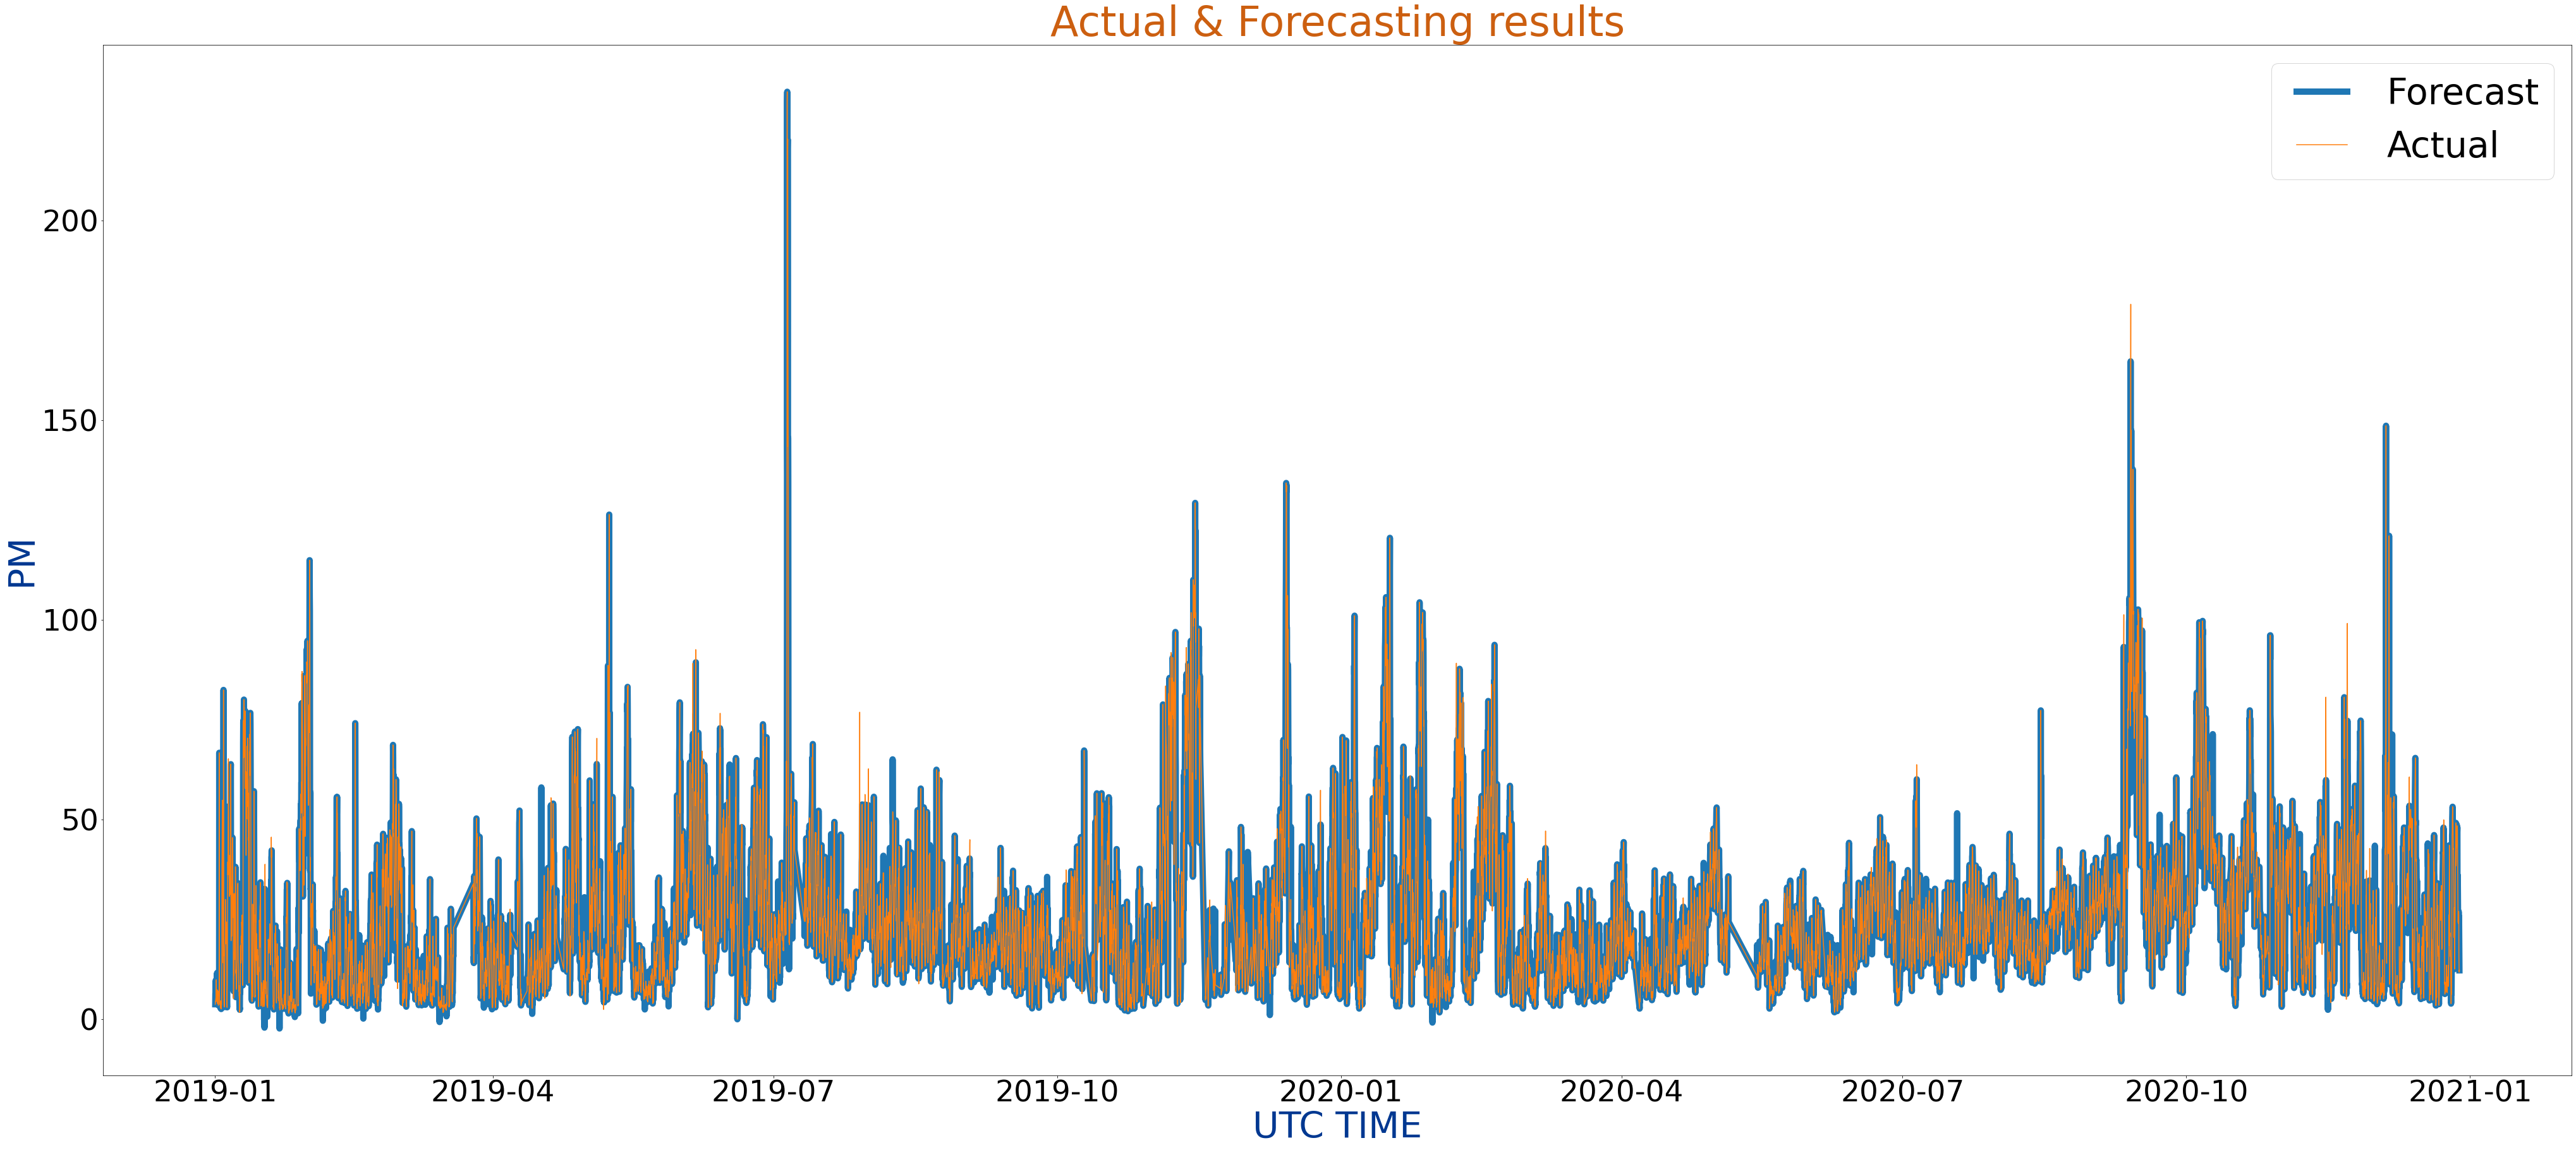

In [14]:
y_pred_hrdata = model.predict(x_hrdata)
plt.plot(hourlydata[0], y_pred_hrdata, label = 'Forecast', linewidth=10)
plt.plot(hourlydata[0], y_hrdata, label = 'Actual')
plt.title('Actual & Forecasting results')
Set_Plot(plt)

In [27]:
import plotly.graph_objs as go
names = ['Forecasted PM', 'Actual PM']
PMs = [y_pred_hrdata, y_hrdata]
fig = go.Figure([{"x": hourlydata[0], 
                  "y": PMs[ind], 
                  "name": names[ind]} for ind in range(1)])
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6hrs", step="hour", stepmode="backward"),
                         dict(count=1, label="1d", step="day", stepmode="backward"),
                         dict(count=7, label="1w", step="day", stepmode="backward"),
                         dict(count=1, label="1m", step="month", stepmode="backward"),
                         dict(step="all")]
                     )))
fig.update_layout(
    title='Time series for PM2.5 concentrations - Predicted',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(240, 240, 240)')
fig.show()

## Forecasting Temperature

In [20]:
x_hrdata_temp = pd.DataFrame({ 'weekday':[x.weekday() for x in hourlydata[0]],
                         'date':[x.day for x in hourlydata[0]], 
                      'month':[x.month for x in hourlydata[0]], 
                      'year':[x.year for x in hourlydata[0]], 
                      'hour':[x.hour for x in hourlydata[0]],})
y_hrdata_temp = pd.Series(hourlydata[2])

x_hrdata_temp.head(), ' ',  y_hrdata_temp.head()

(   weekday  date  month  year  hour
 0        1     1      1  2019     0
 1        1     1      1  2019     1
 2        1     1      1  2019     2
 3        1     1      1  2019     3
 4        1     1      1  2019     5, ' ', 0    55.818182
 1    53.977273
 2    53.622222
 3    53.372093
 4    51.409091
 dtype: float64)

In [21]:
x_train_temp, x_test_temp, y_train_temp, y_test_temp = train_test_split(x_hrdata_temp, y_hrdata_temp, test_size=0.2)
#gradient regressor model
gradRegressor = gbr(max_depth=8, n_estimators=2000, learning_rate=0.4)

model_temp = gradRegressor.fit(x_train_temp, y_train_temp)
y_pred_temp = model_temp.predict(x_test_temp)
r2_score(y_true=y_test_temp, y_pred=y_pred_temp)

0.9669271852669116

## Forecasting Humidity

In [22]:
x_hrdata_hdt = pd.DataFrame({ 'weekday':[x.weekday() for x in hourlydata[0]],
                         'date':[x.day for x in hourlydata[0]], 
                      'month':[x.month for x in hourlydata[0]], 
                      'year':[x.year for x in hourlydata[0]], 
                      'hour':[x.hour for x in hourlydata[0]],
                      'temp':hourlydata[2]})
y_hrdata_hdt = pd.Series(hourlydata[3])

x_hrdata_hdt.head(), ' ',  y_hrdata_hdt.head()

(   weekday  date  month  year  hour       temp
 0        1     1      1  2019     0  55.818182
 1        1     1      1  2019     1  53.977273
 2        1     1      1  2019     2  53.622222
 3        1     1      1  2019     3  53.372093
 4        1     1      1  2019     5  51.409091, ' ', 0    17.136364
 1    19.204545
 2    19.311111
 3    16.906977
 4    17.181818
 dtype: float64)

In [23]:
x_train_hdt, x_test_hdt, y_train_hdt, y_test_hdt = train_test_split(x_hrdata_hdt, y_hrdata_hdt, test_size=0.2)
#gradient regressor model
gradRegressor = gbr(max_depth=8, n_estimators=2000, learning_rate=0.4)

model_hdt = gradRegressor.fit(x_train_hdt, y_train_hdt)
y_pred_hdt = model_hdt.predict(x_test_hdt)
r2_score(y_true=y_test_hdt, y_pred=y_pred_hdt)

0.9331838735604501

## 6-Months Forecast using GBR

In [24]:
from datetime import timedelta
dt = datetime(2021, 1, 1, 0, 0, 0)
print(dt)

total_hours = 24 * 6 * 30
forecast_dates = [dt]

for hr in range(total_hours):
  dt += timedelta(hours = 1)
  forecast_dates.append(dt)

forecast_dates[len(forecast_dates)-1]

2021-01-01 00:00:00


datetime.datetime(2021, 6, 30, 0, 0)

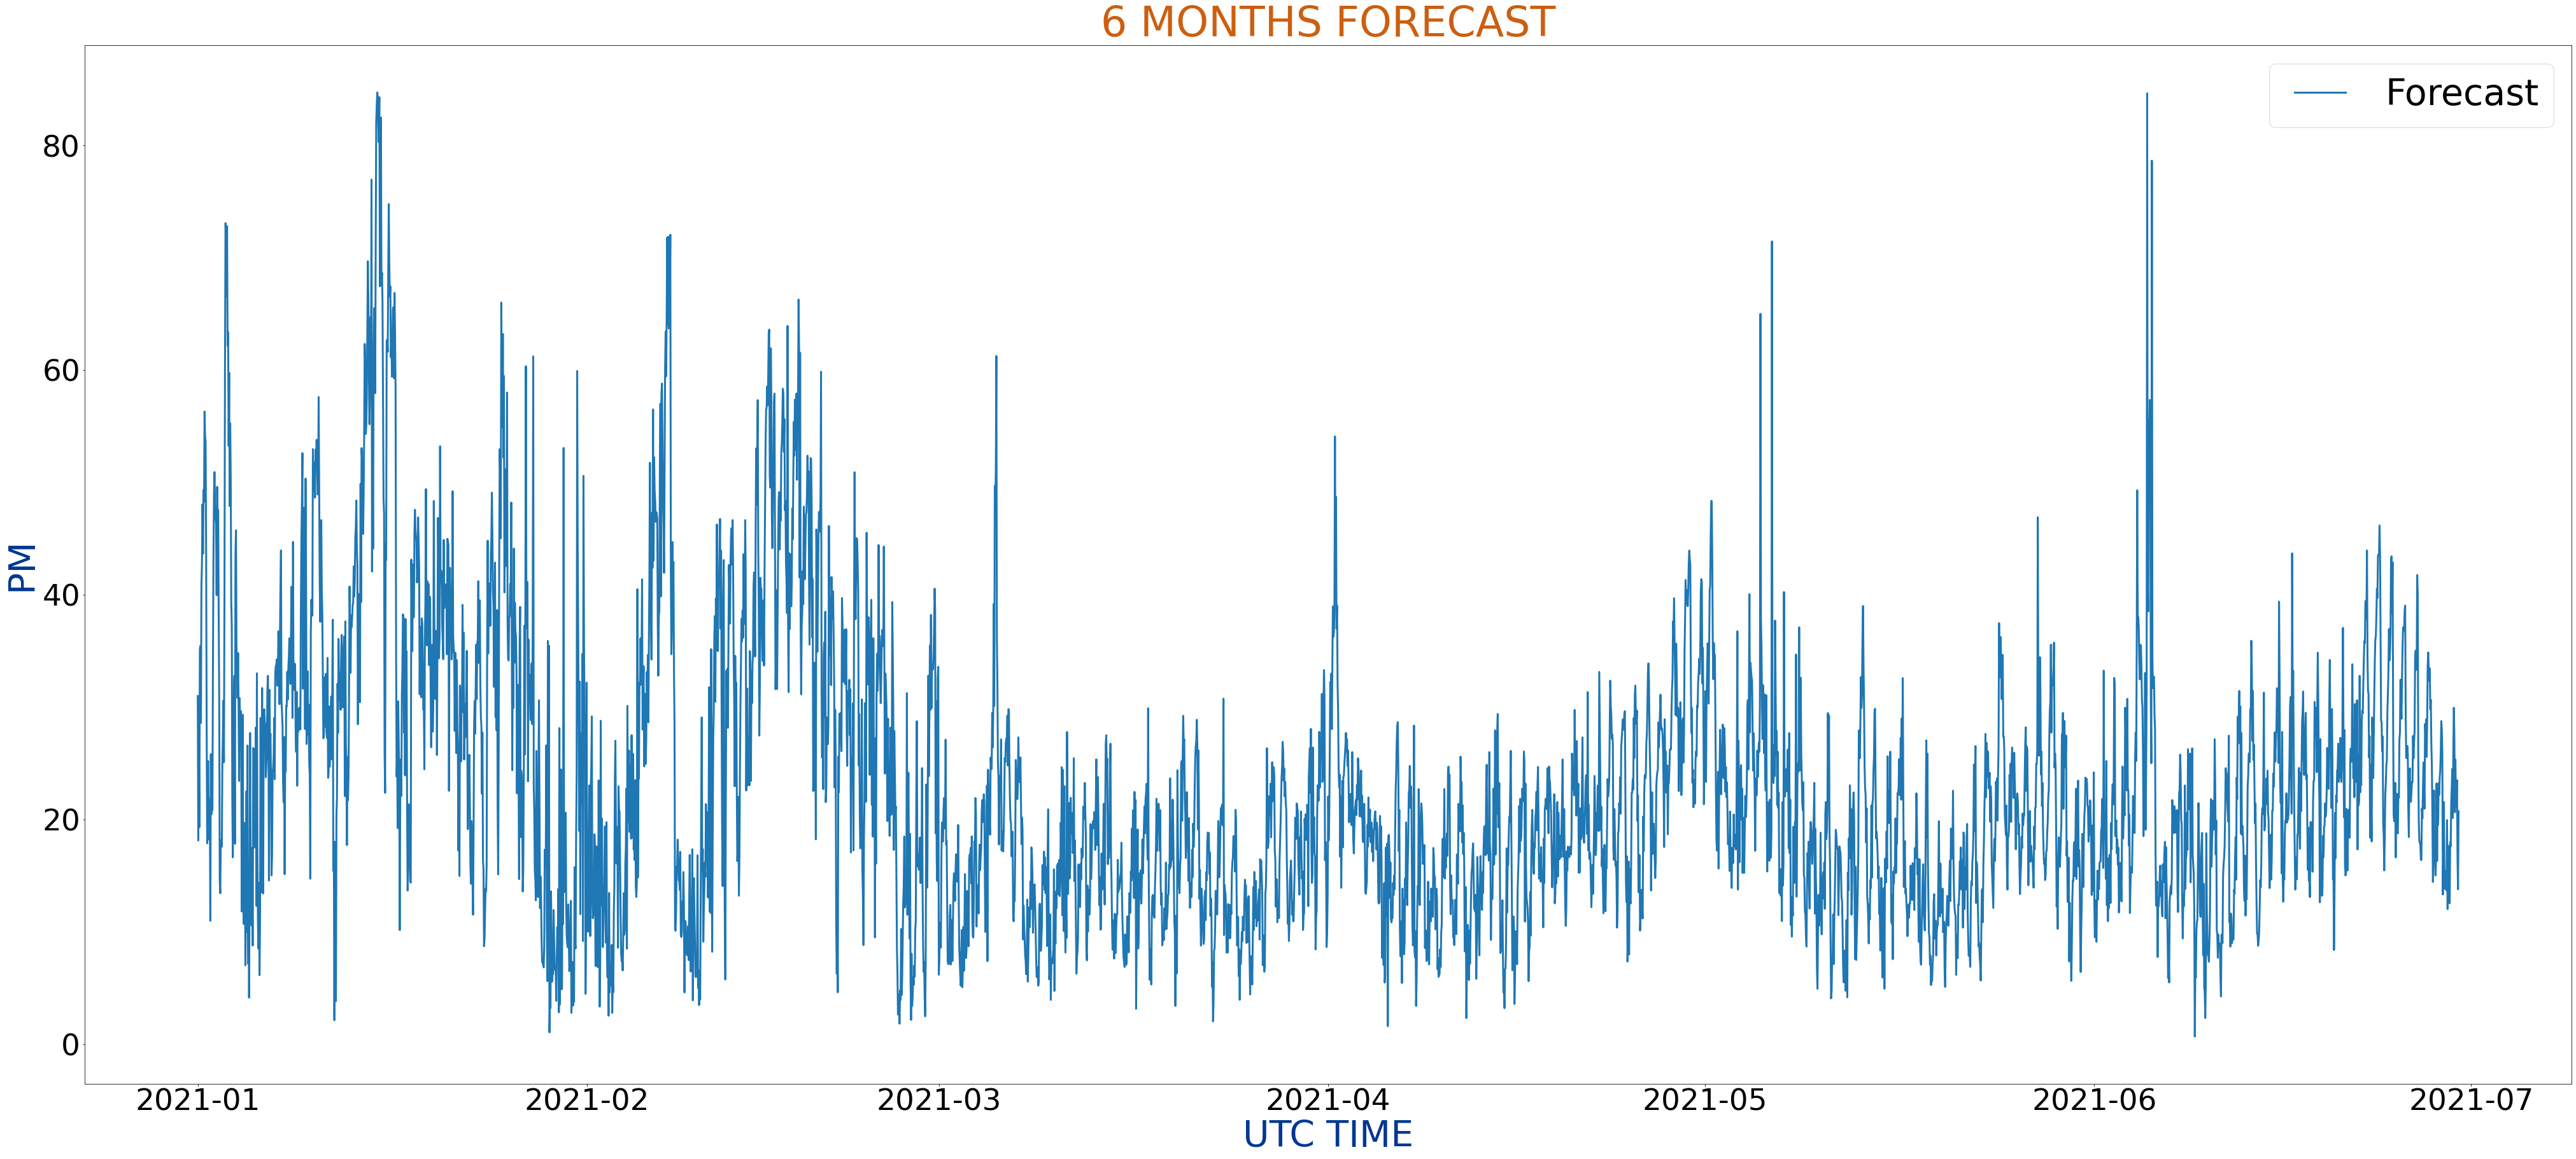

In [25]:
x_hrdata_forecast = pd.DataFrame({ 'weekday':[x.weekday() for x in forecast_dates],
                         'date':[x.day for x in forecast_dates], 
                      'month':[x.month for x in forecast_dates], 
                      'year':[x.year for x in forecast_dates], 
                      'hour':[x.hour for x in forecast_dates]})

# predict Temperature
temp_hrdata_forecast = model_temp.predict(x_hrdata_forecast)
x_hrdata_forecast['temp'] = [x for x in temp_hrdata_forecast]

# predict Humidity 
hdt_hrdata_forecast = model_hdt.predict(x_hrdata_forecast)
x_hrdata_forecast['humidity'] = [x for x in hdt_hrdata_forecast]

# predict PM-2.5
y_pred_hrdata_forecast = model.predict(x_hrdata_forecast)
plt.plot(forecast_dates, y_pred_hrdata_forecast, label = 'Forecast', linewidth=3)
plt.title('6 MONTHS FORECAST')
Set_Plot(plt)

In [28]:
import plotly.graph_objs as go
names = ['Forecasted PM']
PMs = [y_pred_hrdata_forecast]
fig = go.Figure([{"x": forecast_dates, 
                  "y": PMs[ind], 
                  "name": names[ind]} for ind in range(1)])
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6hrs", step="hour", stepmode="backward"),
                         dict(count=1, label="1d", step="day", stepmode="backward"),
                         dict(count=7, label="1w", step="day", stepmode="backward"),
                         dict(count=1, label="1m", step="month", stepmode="backward"),
                         dict(step="all")]
                     )))
fig.update_layout(
    title='Time series for PM2.5 concentrations - Forecasted - 2021',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(240, 240, 240)')
fig.show()